This notebook makes projections for the Gecco telescope. Currently it uses the same target region as COMPTEL and a background model derived from COMPTEL and EGRET data (see eq. 14 [here](https://arxiv.org/pdf/1504.04024)).

We need to think about what targets and background models make sense. We should probably do projections for the Galactic Center, dSphs, and ROIs of other experiments. One issue with dSph projections is that Gecco's angular resolution is quite poor ($\sim 6^\circ$), so we'll need to account for this properly.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jupyter_beeper
from collections import defaultdict
from hazma.gamma_ray_parameters import egret_diffuse, fermi_diffuse, comptel_diffuse, gecco_bg_model
from hazma.gamma_ray_parameters import A_eff_comptel, A_eff_egret, A_eff_fermi, energy_res_comptel, BackgroundModel
from hazma.gamma_ray_parameters import (
    gc_target, gc_bg_model, draco_target, default_bg_model
)
from hazma.gamma_ray_parameters import (
    A_eff_e_astrogam, energy_res_e_astrogam, T_obs_e_astrogam, TargetParams
)
from hazma.gamma_ray_parameters import (
    A_eff_gecco, energy_res_gecco, energy_res_gecco_large, draco_target
)

from hazma.scalar_mediator import HiggsPortal, HeavyQuark
from hazma.vector_mediator import KineticMixing, QuarksOnly
from hazma.single_channel import SingleChannel

In [3]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]
beeper = jupyter_beeper.Beeper()

def beep():
    return beeper.beep(frequency=900, secs=0.7, blocking=True)

# Setup and utils

In [24]:
# Masses to scan over
mx_min = 0.55  # a bit larger than m_e
mx_max = 250.
n_mxs = 25
mxs = np.geomspace(mx_min, mx_max, n_mxs)

# Other constants
T_obs_gecco = 1e6  # s. From Alex.
v_mw = 1e-3
x_kd = 1e-6


def get_sv_constraints(model, mxs=mxs):
    """
    Computes constraints on <sigma v> for a model over a grid of DM masses.
    """
    constraints = {k: np.zeros_like(mxs) for k in [
        "comptel", "egret", "fermi", "e_astrogam", "gecco_comptel", "gecco_egret",
        "gecco_fermi", "gecco_gc", "gecco_draco", "comptel_check", "cmb",
    ]}

    for i, mx in enumerate(mxs):
        model.mx = mx
        
        # Constraints from existing data
        constraints["comptel"][i] = model.binned_limit(comptel_diffuse)
        constraints["egret"][i] = model.binned_limit(egret_diffuse)
        constraints["fermi"][i] = model.binned_limit(fermi_diffuse)
        
        # Projections
        constraints["e_astrogam"][i] = model.unbinned_limit(
            A_eff_e_astrogam, energy_res_e_astrogam, T_obs_e_astrogam,
            gc_target, gc_bg_model
        )

        constraints["gecco_gc"][i] = model.unbinned_limit(
            A_eff_gecco, energy_res_gecco, T_obs_gecco, gc_target, gc_bg_model
        )
        
        # CMB
        constraints["cmb"][i] = model.cmb_limit(x_kd=x_kd)
    
    return constraints


def get_constraint_label(key):
    if key == "comptel_check":
        return "COMPTEL check"
    elif key == "e_astrogam":
        return "e-ASTROGAM"
    elif key == "gecco_comptel":
        return "GECCO (COMPTEL)"
    elif key == "gecco_egret":
        return "GECCO (EGRET)"
    elif key == "gecco_fermi":
        return "GECCO (Fermi)"
    elif key == "gecco_gc":
        return "GECCO (GC)"
    elif key == "gecco_draco":
        return "GECCO (Draco)"
    elif key == "gecco_large":
        return "GECCO (large)"
    else:
        return key.upper()

def get_fs_label(fs):
    if fs == "e e":
        return r"$e^+ e^-$"
    elif fs == "mu mu":
        return r"$\mu^+ \mu^-$"
    elif fs == "pi pi":
        return r"$\pi^+ \pi^-$"
    elif fs == "pi0 pi0":
        return r"$\pi^0 \pi^0$"
    elif fs == "pi0 g":
        return r"$\pi^0 \gamma$"
    elif fs == "g g":
        return r"$\gamma \gamma$"
    else:
        return fs

def get_formatted_fig(nrows, ncols, figsize, xlim, ylim):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)

    for ax in axes[-1]:
        ax.set_xlabel(r"$m_\chi$ [MeV]")

    for ax in axes[:, 0]:
        ax.set_ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]")

    for ax in axes.flatten():
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid()

    return fig, axes

# Higgs portal model

In [8]:
mss = [200, 1000]

sm_args = np.array([
    [{"mx": 1., "ms": ms, "gsxx": 1., "stheta": 0.1} for ms in mss],
    [{"mx": 1., "ms": ms, "gsxx": 1., "gsQ": 0.1, "mQ": 1000, "QQ": 1} for ms in mss],
])

SMs = np.array([
    [HiggsPortal, HiggsPortal],
    [HeavyQuark, HeavyQuark]
])

# Instantiate all the models
sms = np.vectorize(lambda SM, kwargs: SM(**kwargs))(SMs, sm_args)

In [29]:
# Recompute constraints
sv_constraints_sms = np.empty_like(sms)
for i in range(len(sms)):
    for j in range(len(sms[i])):
        sv_constraints_sms[i, j] = get_sv_constraints(sms[i, j], mxs)

# Save results
# np.savez(
#     "data/sv_constraints_sms.npz", sv_constraints_sms=sv_constraints_sms, sm_args=sm_args
# )

# sv_constraints_sms = np.load(
#     "data/sv_constraints_sms.npz", allow_pickle=True
# )["sv_constraints_sms"]

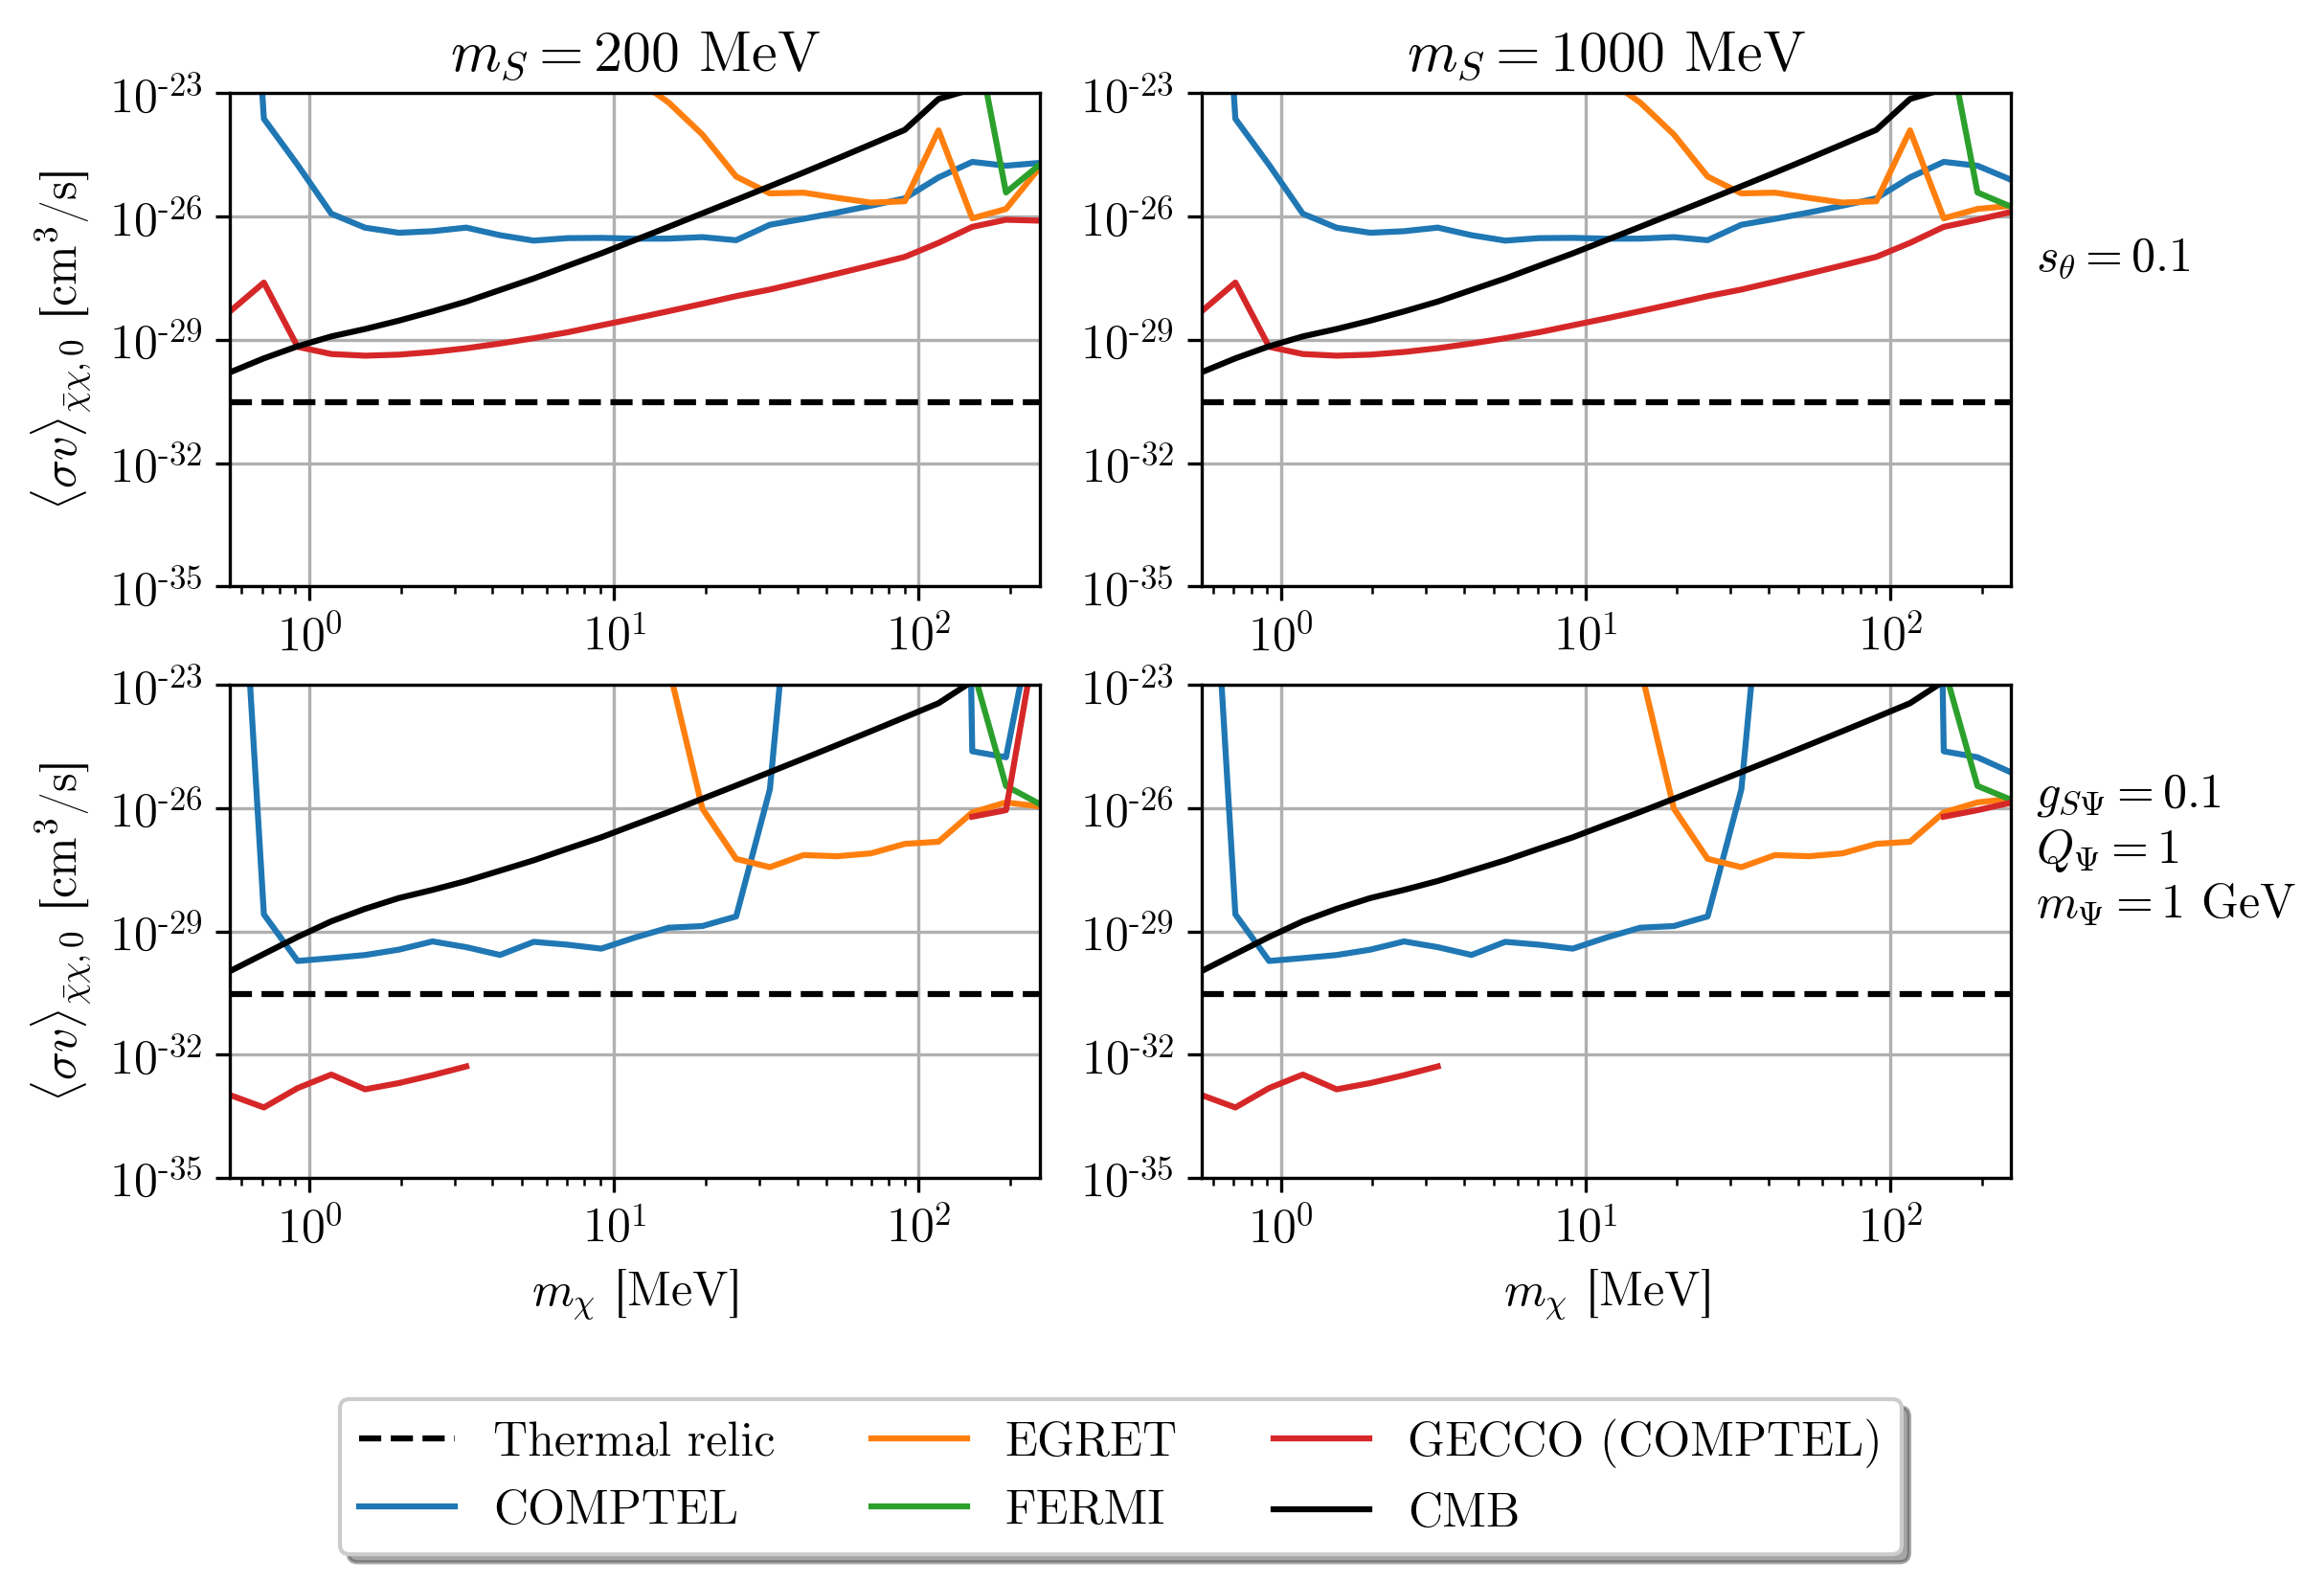

In [35]:
fig, axes = get_formatted_fig(
    *sms.shape, (4 * sms.shape[1], 2.5 * sms.shape[0]),
    mxs[[0, -1]], (1e-35, 1e-23)
)

# Current constraints
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i, j]
        
        # Relic cross section tranlated to <sigma v> in the Milky Way
        v_fo = np.sqrt(1/10)
        ax.axhline(
            3e-26 * (v_mw / v_fo)**2, linestyle="--", color="k", label="Thermal relic"
        )
        
        # Constraints
        for key, svs in sv_constraints_sms[i, j].items():
            if key in ["comptel_check", "gecco_large", "e_astrogam", 'gecco_gc', 'gecco_egret', 'gecco_fermi', 'gecco_draco']:
                continue
            elif key == "cmb":
                v_cmbs = 2e-4 * (0.235) * (1 / mxs) * np.sqrt(1e-4 / x_kd)
                ax.plot(mxs, svs * (v_mw / v_cmbs)**2, "k", label=r"CMB")
            else:
                ax.plot(mxs, svs, label=get_constraint_label(key))

# Mediator mass labels
for ms, ax in zip(mss, axes[0]):
    ax.set_title(r"$m_S = $" + f"{ms} MeV")

# Coupling labels  ---------------
row_labels = [
    r"$s_\theta = %.1f$" % sms[0, -1].stheta,
    r"$g_{S\Psi} = %.1f$" % sms[1, -1].gsQ + "\n"
    + r"$Q_\Psi = %i$" % sms[1, -1].QQ + "\n"
    + r"$m_\Psi = %i$ GeV" % (sms[1, -1].mQ / 1000)
]
for label, ax in zip(row_labels, axes[:, -1]):
    ax.text(3e2, 1e-27, label, va="center")

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/sm_comptel.png", bbox_inches="tight")

In [9]:
beep()

## Understanding gap in heavy quark model

In [13]:
mxs = np.geomspace(mx_min, mx_max, 100)

sv_gecco = np.zeros(len(mxs))
sm = sms[1, 1]

for i, mx in enumerate(mxs):
    sm.mx = mx
    print(mx)
    sv_gecco[i] = sm.unbinned_limit(
        A_eff_gecco, energy_res_gecco, T_obs_gecco, comptel_diffuse.target,
        default_bg_model, debug_msgs=True
    )

0.55
	e_a, e_b = 0.46166663340637953, 0.5832855772083002; -1650.1877330616312
0.5850687538727356
	e_a, e_b = 0.5688893083466786, 0.6076641248626786; -3297.7788732531467
0.6223735395603557
	e_a, e_b = 0.5901052765254281, 0.661704277667332; -2641.095659218302
0.6620569295162563
	e_a, e_b = 0.6504360397663269, 0.7518234754380413; -2483.461460922321
0.7042705868088829
	e_a, e_b = 0.6881883404450958, 1.2051027848767886; -1439.2876843023926
0.7491758447518061
	e_a, e_b = 0.7325068922628875, 0.7934190558641931; -3597.360608530171
0.7969443234918057
	e_a, e_b = 0.788448759978593, 0.805644754036132; -5992.911670499436
0.8477585859114564
	e_a, e_b = 0.8305963500103407, 1.231082542954647; -1864.444298716217
0.9018128353529603
	e_a, e_b = 0.8828299818187394, 0.9305636259639914; -4932.355754454972
0.9593136578298089
	e_a, e_b = 0.9335812662709343, 0.9829360328746231; -5176.451984377609
1.0204808115628765
	e_a, e_b = 1.0148423109768703, 1.071927686285044; -4121.173844633162
1.0855480668584183
	e_a, 

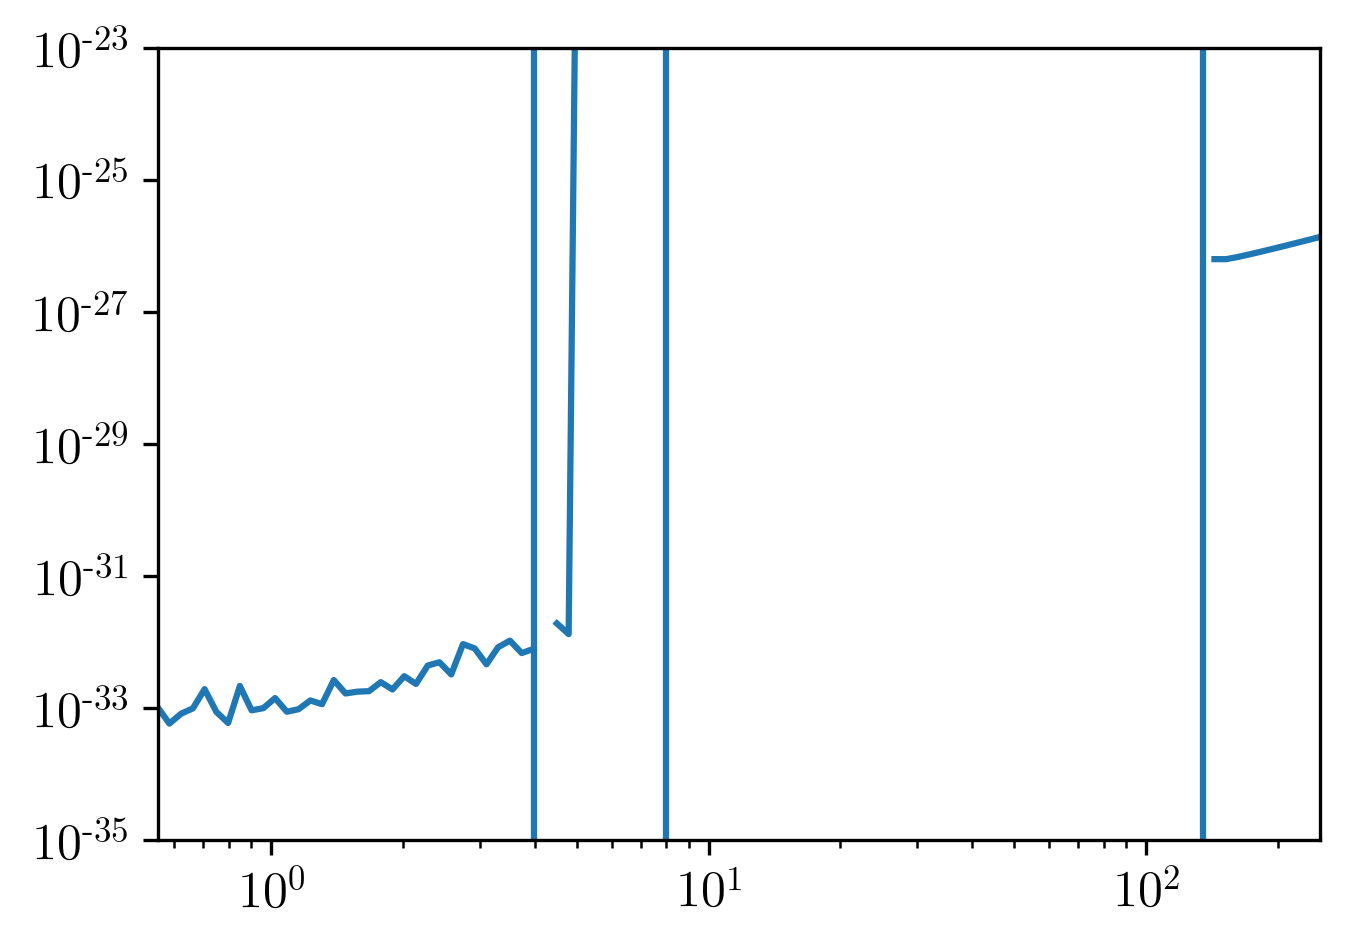

In [16]:
plt.loglog(mxs, sv_gecco)
plt.xlim(mxs[[0, -1]])
plt.ylim(1e-35, 1e-23)
plt.axvline(0.3)
plt.axvline(7.98/2)
plt.axvline(7.98)
plt.axvline(135)

# Vector

In [32]:
mvs = [200, 1000]

vm_args = np.array([
    [{"mx": 1., "mv": mv, "gvxx": 1., "eps": 0.1} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": -1, "gvss": 0.} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": 1, "gvss": 0.} for mv in mvs]
])

VMs = np.array([
    [KineticMixing, KineticMixing],
    [QuarksOnly, QuarksOnly],
    [QuarksOnly, QuarksOnly]
])

# Instantiate all the models
vms = np.vectorize(lambda VM, args: VM(**args))(VMs, vm_args)

In [33]:
# Recompute constraints
sv_constraints_vms = np.empty_like(vms)
for i in range(len(vms)):
    for j in range(len(vms[i])):
        sv_constraints_vms[i, j] = get_sv_constraints(vms[i, j], mxs)

# Save results
np.savez(
    "data/sv_constraints_vms.npz", sv_constraints_vms=sv_constraints_vms, vm_args=vm_args
)

# # Load precomputed constraints
# sv_constraints_vms = np.load(
#     "data/sv_constraints_vms.npz", allow_pickle=True
# )["sv_constraints_vms"]

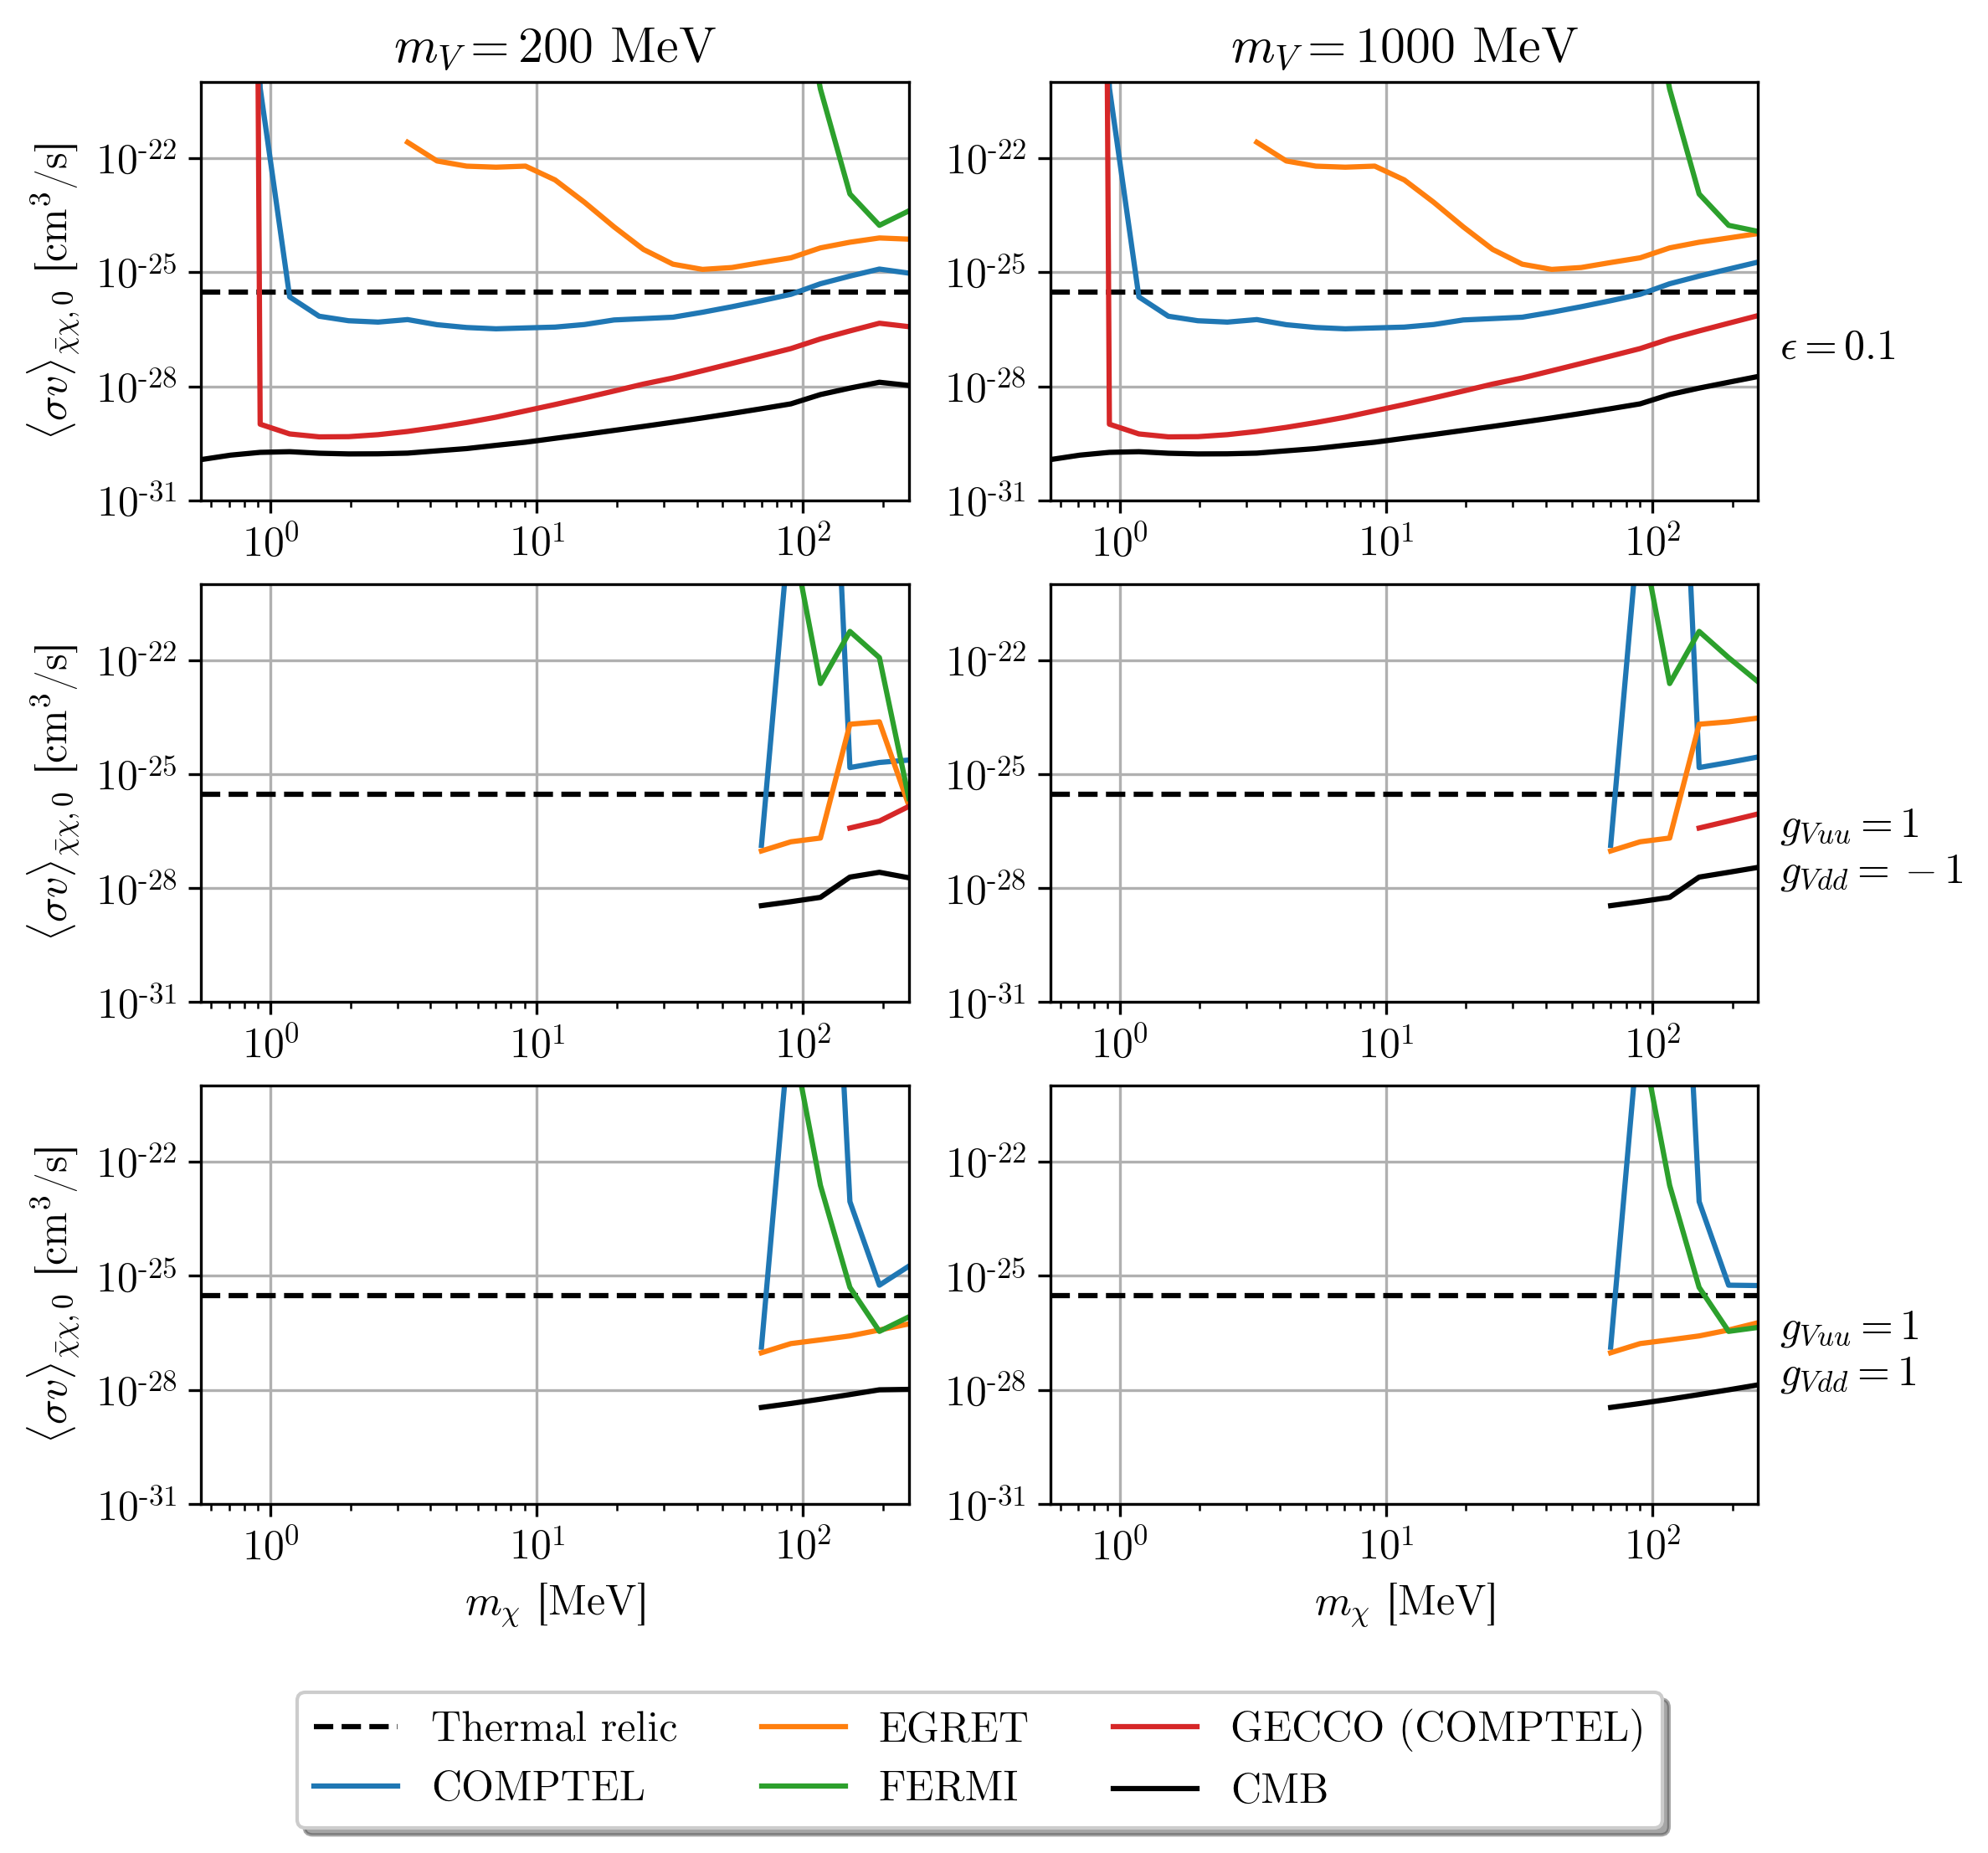

In [36]:
fig, axes = get_formatted_fig(
    *vms.shape, (4 * vms.shape[1], 2.5 * vms.shape[0]),
    mxs[[0, -1]], (1e-31, 1e-20)
)

# Current constraints
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i, j]
        
        # Thermal relic cross section
        ax.axhline(3e-26, linestyle="--", color="k", label="Thermal relic")
        
        # Constraints
        for key, svs in sv_constraints_vms[i, j].items():
            if key in ["comptel_check", "gecco_large", "e_astrogam", 'gecco_gc', 'gecco_egret', 'gecco_fermi', 'gecco_draco']:
                continue
            elif key == "cmb":
                ax.plot(mxs, svs, "k", label=r"CMB")
            else:
                ax.plot(mxs, svs, label=get_constraint_label(key))

# Mediator mass labels
for mv, ax in zip(mvs, axes[0]):
    ax.set_title(r"$m_V = $" + f"{mv} MeV")

# Coupling labels
row_labels = [
    r"$\epsilon = %.1f$" % vms[0, -1].eps,
    r"$g_{Vuu} = %i$" % vms[1, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[1, -1].gvdd,
    r"$g_{Vuu} = %i$" % vms[2, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[2, -1].gvdd,
]
for label, ax in zip(row_labels, axes[:, -1]):
    ax.text(3e2, 1e-27, label, va="center")

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/vm_comptel.png", bbox_inches="tight")

In [38]:
T_obs_gecco / 1e6

1.0

In [24]:
beeper.beep(frequency=900, secs=0.7, blocking=True)

# Model-independent constraints

In [5]:
fss = ["e e", "mu mu", "pi pi", "pi0 pi0", "g g", "pi0 g"]
sc_constraints = {}

for fs in fss:
    cur_constraints = defaultdict(lambda: np.zeros(len(mxs)))
    model = SingleChannel(1., fs, 1.)
    print("fs:", fs)
    
    for i, mx in enumerate(mxs):
        model.mx = mx

        # Constraints from existing data
        cur_constraints["comptel"][i] = model.binned_limit(comptel_diffuse)
        cur_constraints["egret"][i] = model.binned_limit(egret_diffuse)
        cur_constraints["fermi"][i] = model.binned_limit(fermi_diffuse)

        # Projections
        cur_constraints["gecco_gc"][i] = model.unbinned_limit(
            A_eff_gecco, energy_res_gecco, T_obs_gecco, gc_target, gecco_bg_model,
#             debug_msgs=True
        )

        # CMB
        cur_constraints["cmb"][i] = model.cmb_limit(x_kd=x_kd)
    
    sc_constraints[fs] = cur_constraints

fs: mu mu


/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:57: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_cmb.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  return p_ann * self.mx / self.f_eff(x_kd)
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)


fs: pi0 g
fs: g g
fs: pi pi


/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:38: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


fs: e e
fs: pi0 pi0


In [30]:
# Save constraints
# np.savez("data/sv_constraints_single_channels.npz", {k: dict(v) for k, v in sc_constraints.items()})

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


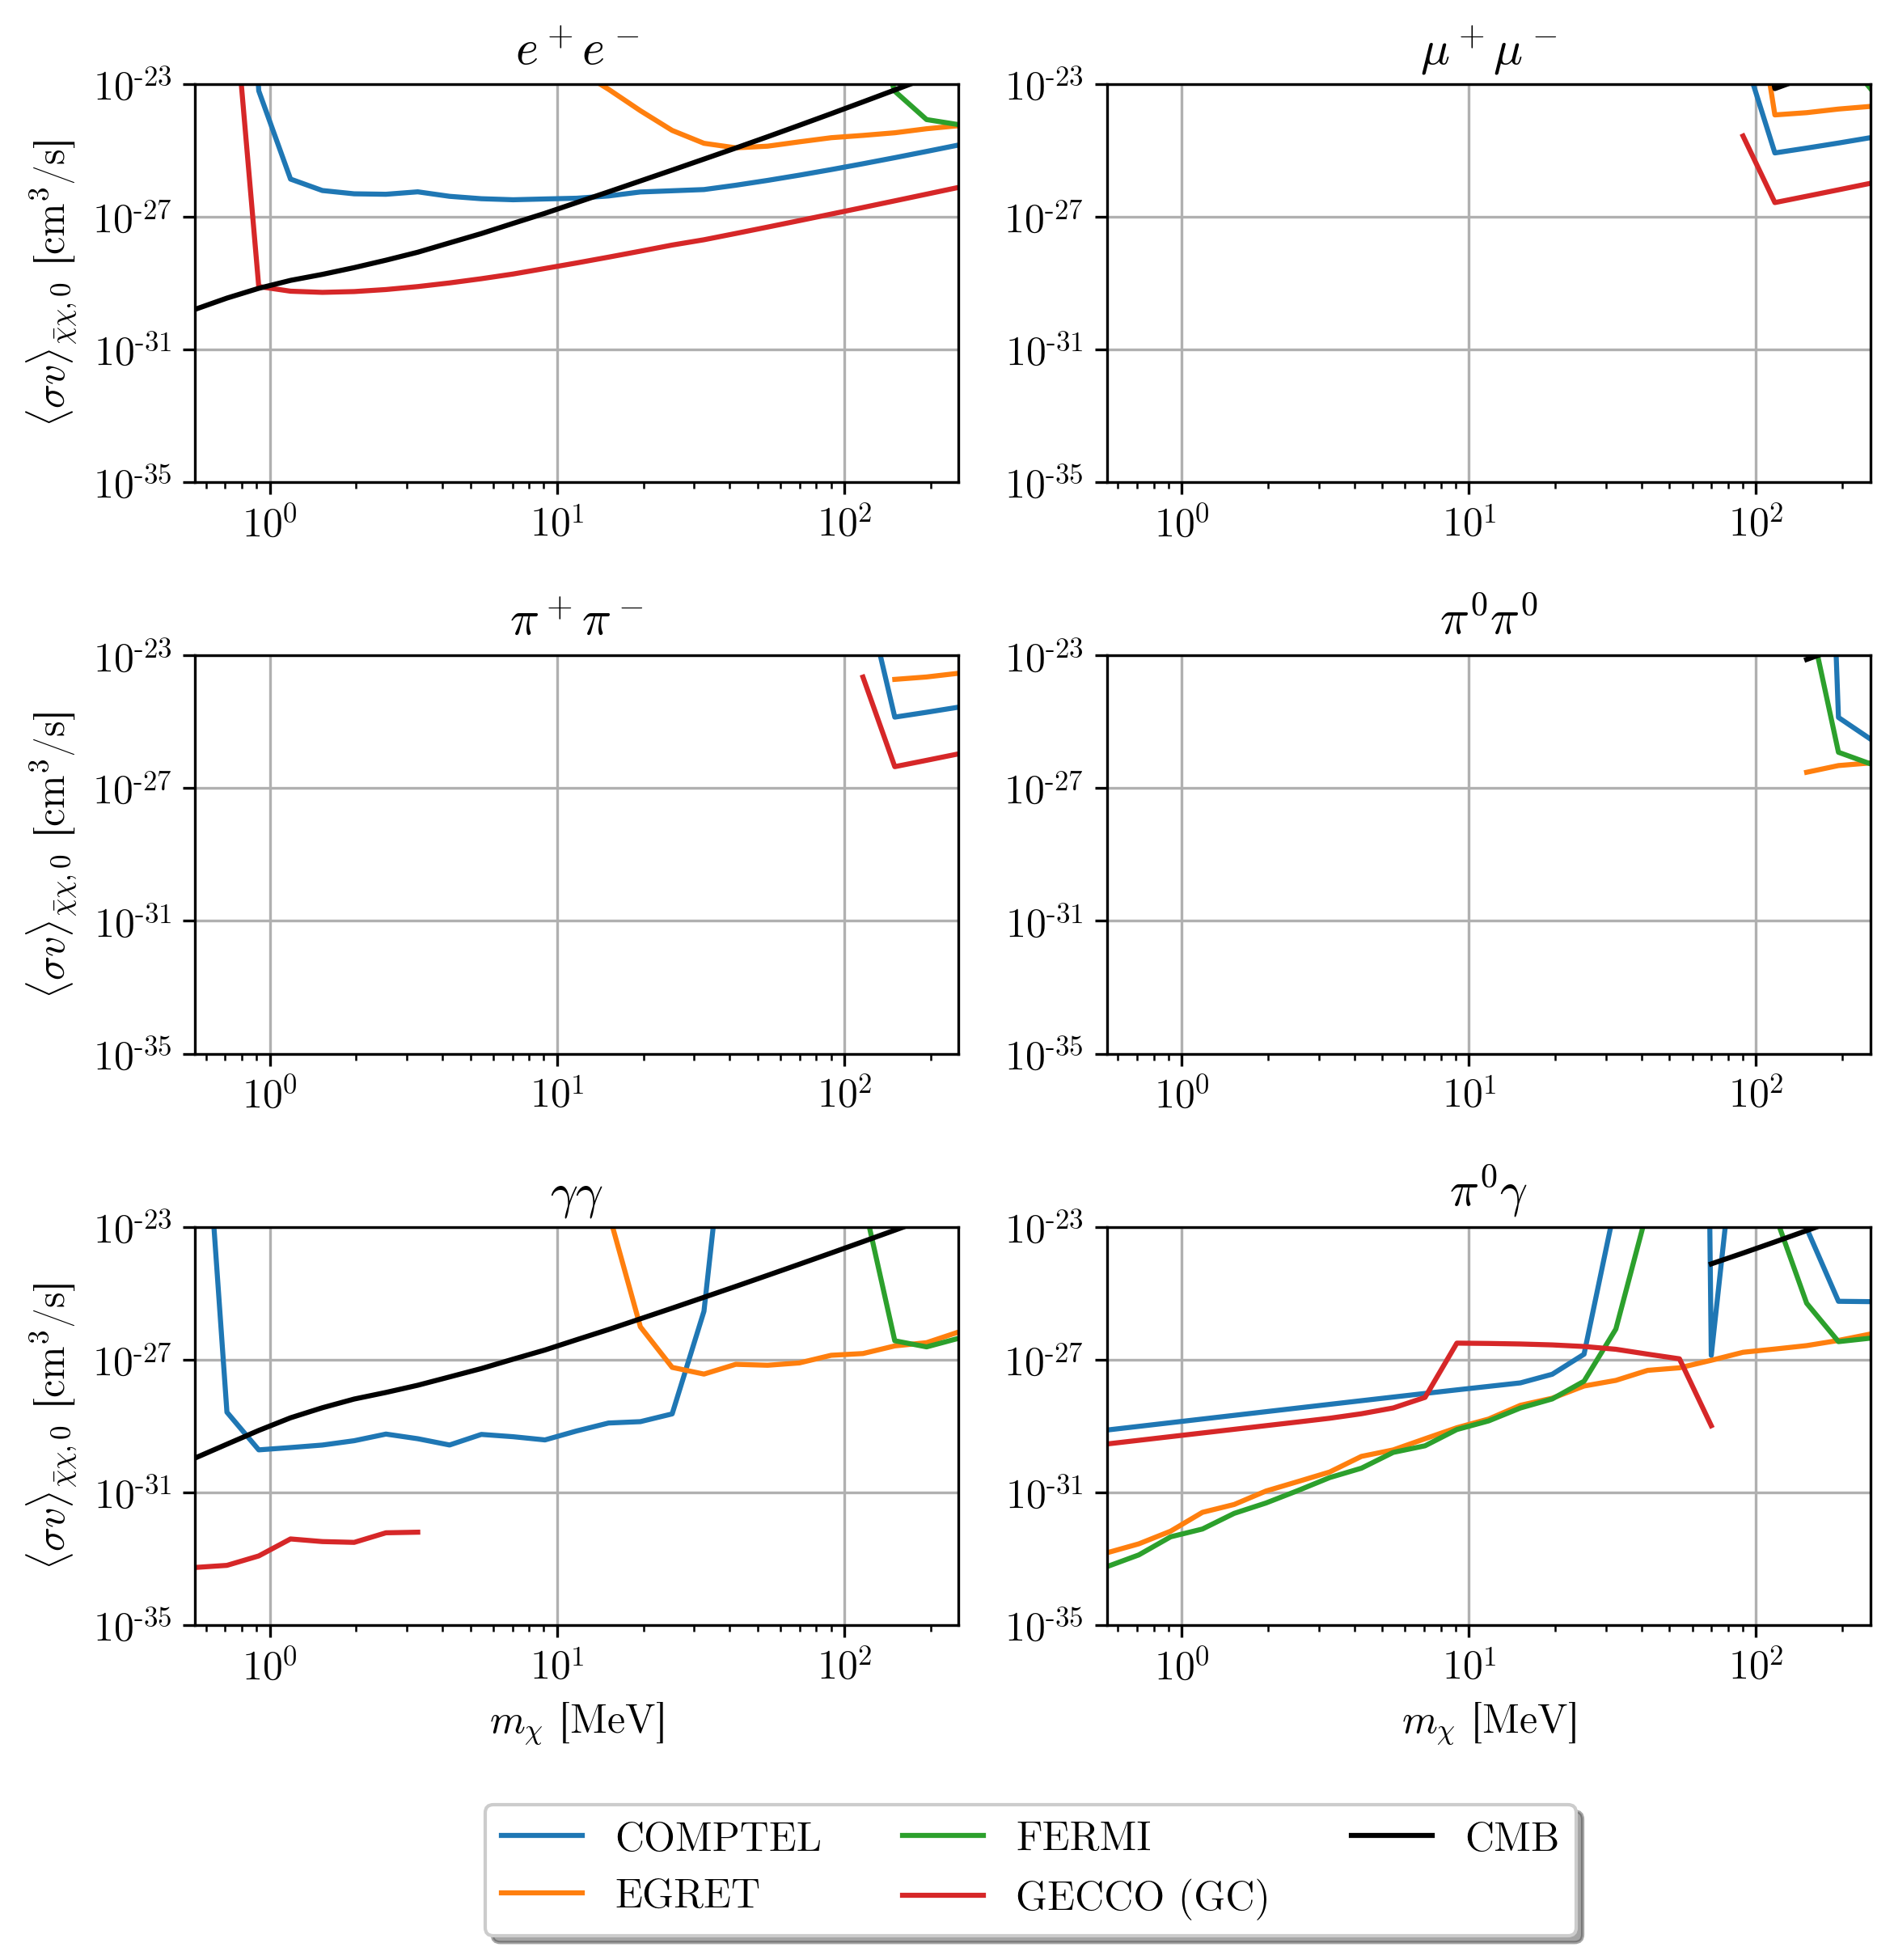

In [32]:
fig, axes = get_formatted_fig(3, 2, (4 * 2, 2.5 * 3), mxs[[0, -1]], (1e-35, 1e-23))

for fs, ax in zip(fss, axes.flatten()):
    ax.set_title(get_fs_label(fs))
    for key, svs in sc_constraints[fs].items():
        if key == "cmb":
            # s-wave
            # ax.plot(mxs, svs, "k", label=r"CMB")
            
            # p-wave
            v_cmbs = 2e-4 * (0.235) * (1 / mxs) * np.sqrt(1e-4 / x_kd)
            ax.plot(mxs, svs * (v_mw / v_cmbs)**2, "k", label=r"CMB")
        else:
            ax.plot(mxs, svs, label=get_constraint_label(key))

fig.tight_layout()

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/single_channel_sigmav_limits.pdf")

In [24]:
mx = 100
sm = HiggsPortal(mx, 1e3, 1, 0.1)
sc_pi0_pi0 = SingleChannel(mx, "pi0 pi0", 1)
sc_pi_pi = SingleChannel(mx, "pi pi", 1)
sc_mu_mu = SingleChannel(mx, "mu mu", 1)
sc_e_e = SingleChannel(mx, "e e", 1)

In [25]:
e_gams = np.geomspace(5e0, 3e2, 1000)
e_cm = 2 * mx * (1 + 1e-3**2)

/Users/acoogan/Dropbox/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:45: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)


(1e-05, 0.1)

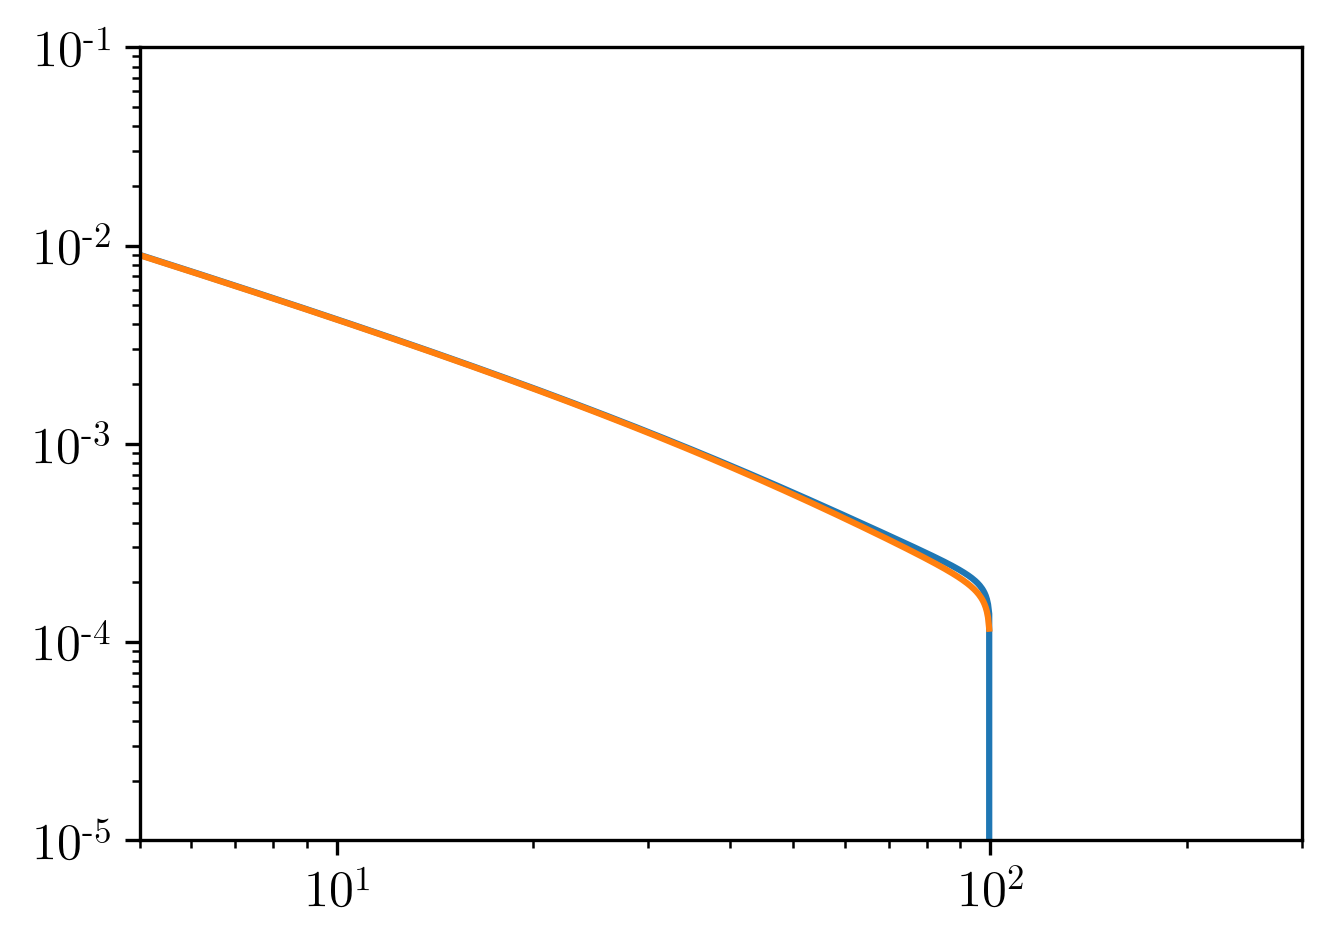

In [27]:
plt.loglog(e_gams, sm.total_spectrum(e_gams, e_cm))
# plt.loglog(e_gams, sc_pi_pi.total_spectrum(e_gams, e_cm) * 1/3 + sc_pi0_pi0.total_spectrum(e_gams, e_cm) * 1/5)
plt.loglog(e_gams, 0.93 * sc_e_e.total_spectrum(e_gams, e_cm))

plt.xlim(e_gams[[0, -1]])
plt.ylim(1e-5, 1e-1)

# Background models

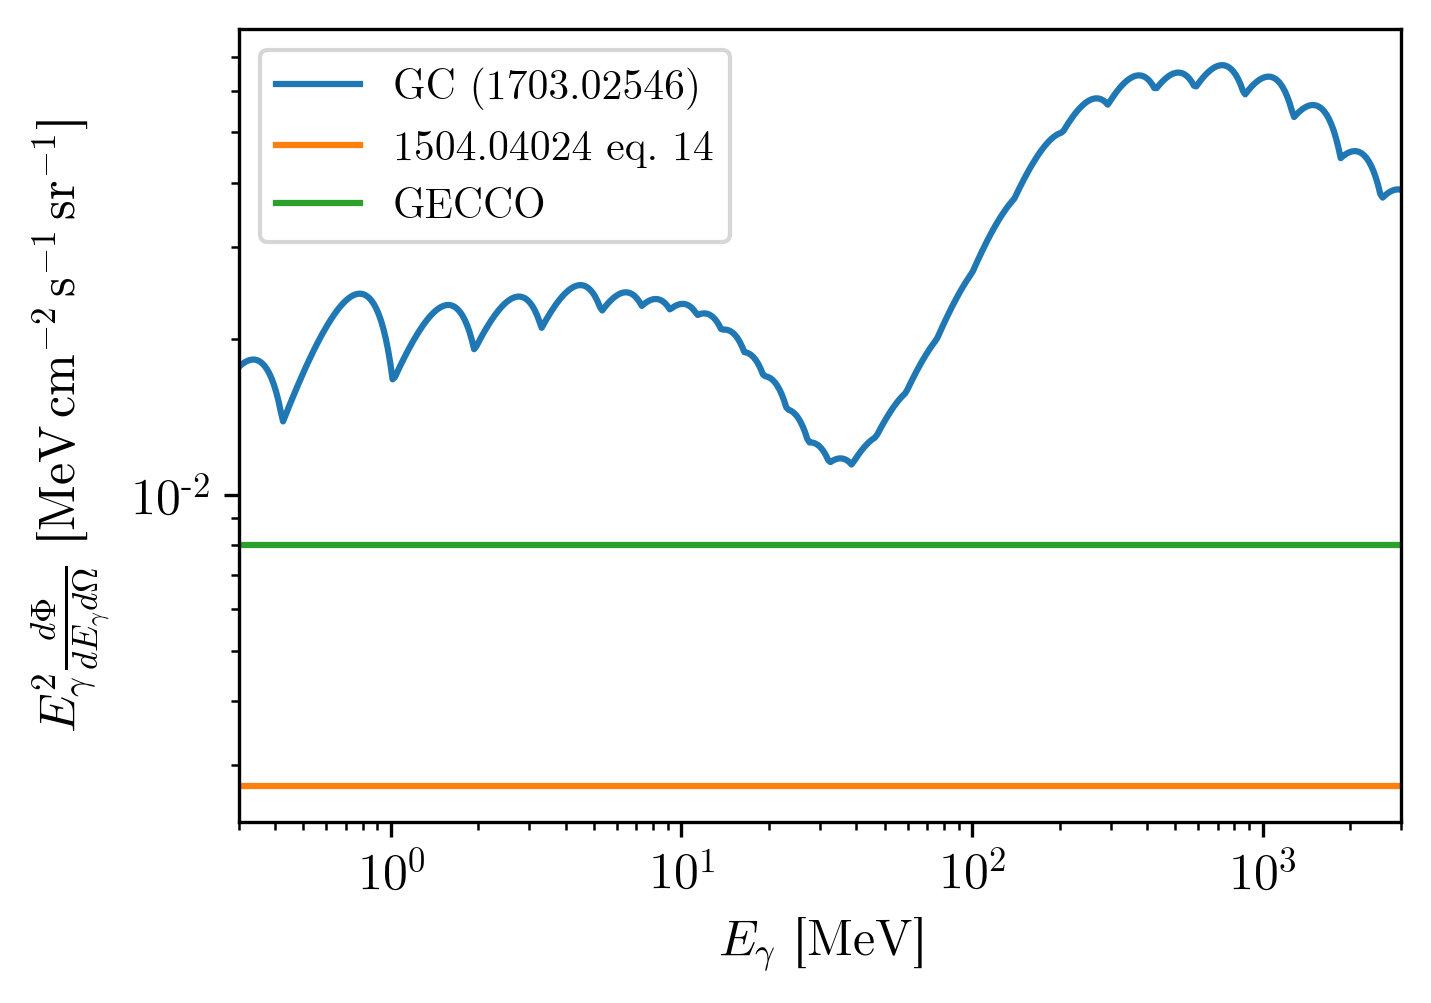

In [35]:
e_gams = np.geomspace(0.3, 3e3, 500)

plt.loglog(e_gams, e_gams**2 * gc_bg_model.dPhi_dEdOmega(e_gams), label="GC (1703.02546)")
plt.loglog(e_gams, e_gams**2 * default_bg_model.dPhi_dEdOmega(e_gams), label="1504.04024 eq. 14")
plt.loglog(e_gams, e_gams**2 * gecco_bg_model.dPhi_dEdOmega(e_gams), label="GECCO")

plt.xlim(e_gams[[0, -1]])
plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$E_\gamma^2 \frac{d\Phi}{dE_\gamma d\Omega}$ [$\mathrm{MeV} \, \mathrm{cm}^{-2} \, \mathrm{s}^{-1} \, \mathrm{sr}^{-1}$]")
plt.legend(fontsize=10)

plt.savefig("figures/gecco/bg_models.png")

# Effective areas

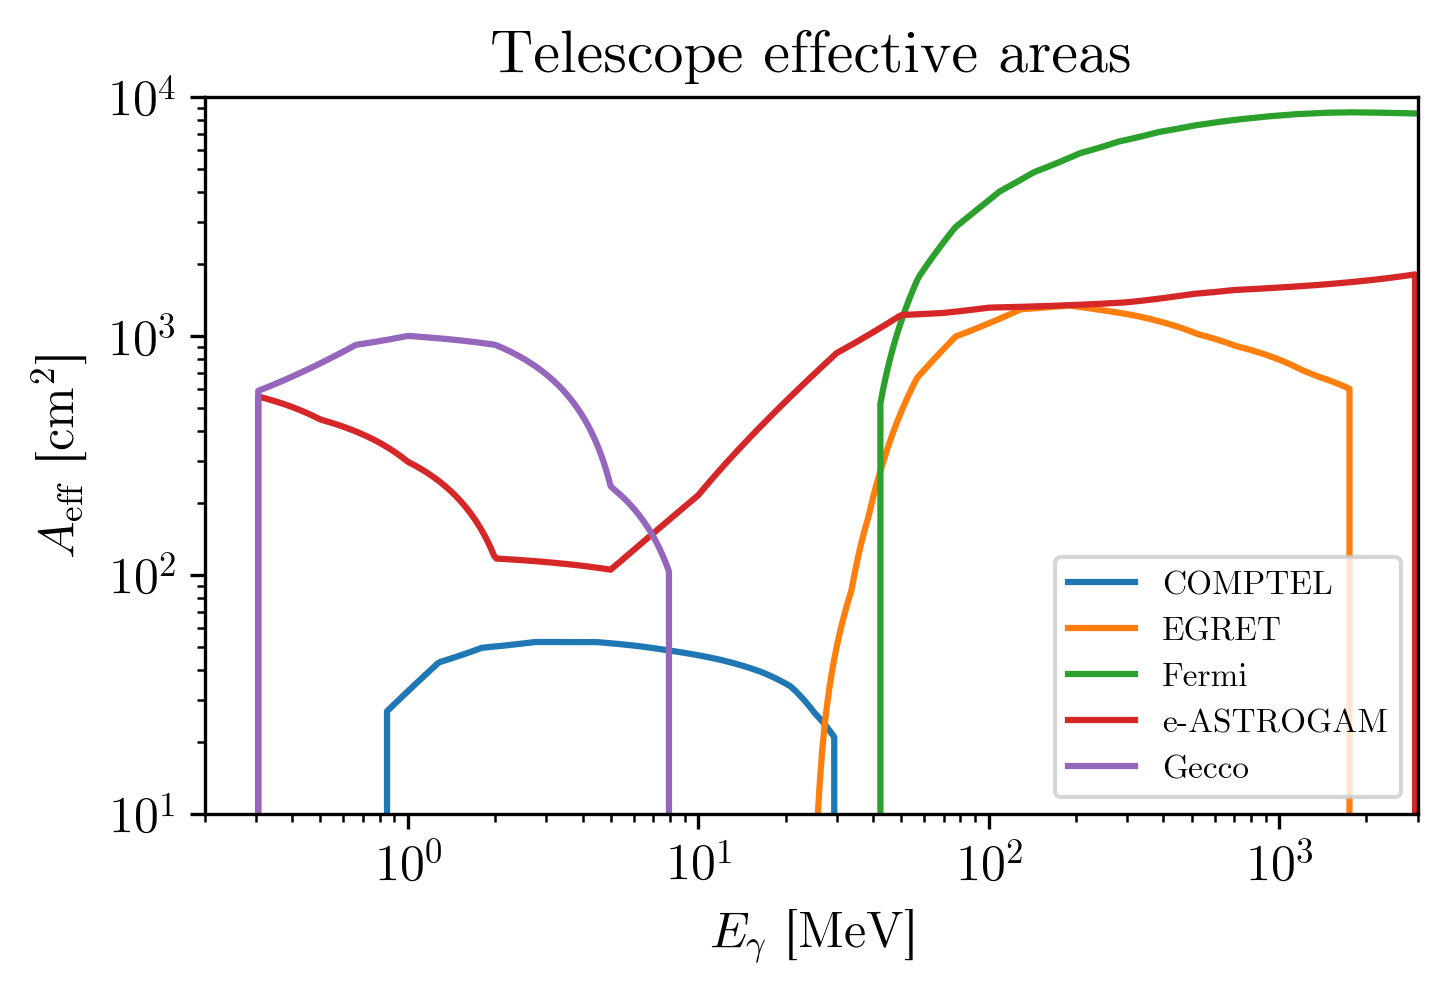

In [31]:
e_gams = np.geomspace(0.2, 3e3, 500)

plt.plot(e_gams, A_eff_comptel(e_gams), label="COMPTEL")
plt.plot(e_gams, A_eff_egret(e_gams), label="EGRET")
plt.plot(e_gams, A_eff_fermi(e_gams), label="Fermi")
plt.plot(e_gams, A_eff_e_astrogam(e_gams), label="e-ASTROGAM")
plt.plot(e_gams, A_eff_gecco(e_gams), label="Gecco")

plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$A_\mathrm{eff}$ [cm$^2$]")
plt.xlim(e_gams[[0, -1]])
plt.ylim(1e1, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=8)
plt.title("Telescope effective areas")

plt.tight_layout()
plt.savefig("figures/gecco/a_eff.png")

# Energy resolution

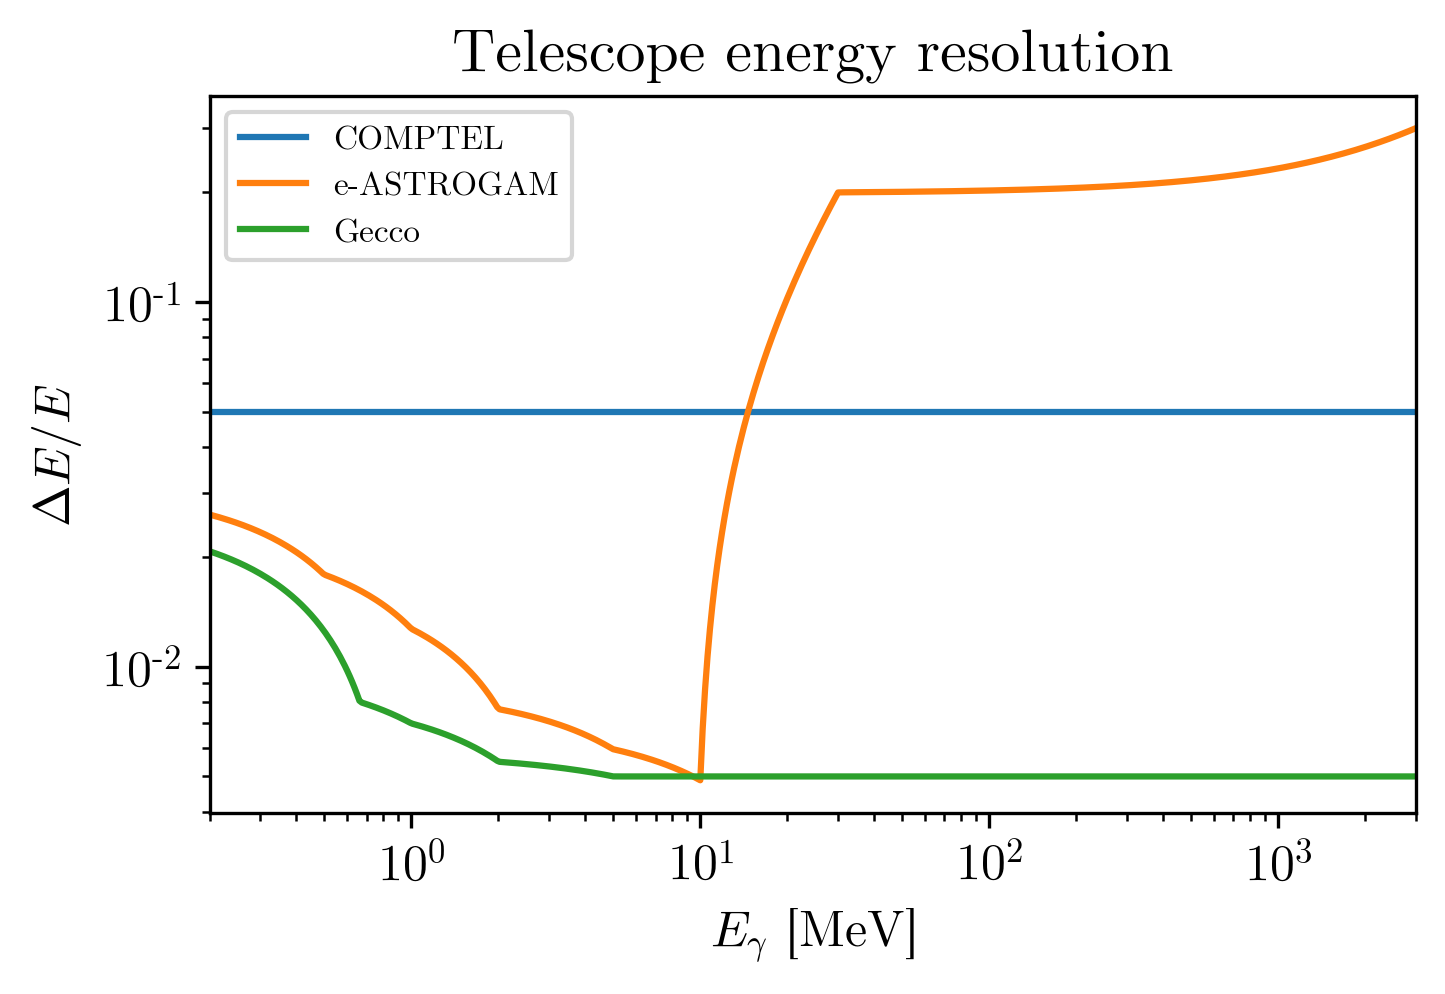

In [32]:
e_gams = np.geomspace(0.2, 3e3, 500)

plt.plot(e_gams, energy_res_comptel(e_gams) * np.ones(len(e_gams)), label="COMPTEL")
plt.plot(e_gams, energy_res_e_astrogam(e_gams), label="e-ASTROGAM")
plt.plot(e_gams, energy_res_gecco(e_gams), label="Gecco")

plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$\Delta E / E$")
plt.xlim(e_gams[[0, -1]])
# plt.ylim(1e1, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=8)
plt.title("Telescope energy resolution")

plt.tight_layout()
plt.savefig("figures/gecco/energy_res.png")